In [1]:
import sys
import os
import findspark
findspark.init()

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import (
    col, to_date, year, month, dayofweek, quarter, weekofyear,
    sum as spark_sum, avg, count, min as spark_min, max as spark_max,
    lag, lead, row_number, dense_rank, date_format
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

os.environ['HADOOP_HOME'] = r'C:\hadoop'
os.environ['PATH'] = r'C:\hadoop\bin' + os.pathsep + os.environ['PATH']

project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✅ Setup complete")

✅ Setup complete


In [2]:
spark = SparkSession.builder \
    .appName("Time Series Analysis") \
    .config("spark.sql.sources.commitProtocolClass", "org.apache.spark.sql.execution.datasources.SQLHadoopMapReduceCommitProtocol") \
    .getOrCreate()

print("\n🔥 Spark session active!")


🔥 Spark session active!


In [3]:
cleaned_path = os.path.join(project_root, 'data', 'cleaned', 'superstore_cleaned_spark.parquet')

print(f"Loading dataset: {cleaned_path}")
start_time = time.time()

df = spark.read.parquet(cleaned_path)

load_time = time.time() - start_time

print(f"\n📊 Dataset loaded in {load_time:.2f} seconds")
print(f"Rows: {df.count():,}")
print(f"Columns: {len(df.columns)}")


Loading dataset: C:\Users\Administrator\Documents\Luxdev\used-cars-analysis-pipeline\data\cleaned\superstore_cleaned_spark.parquet

📊 Dataset loaded in 2.51 seconds
Rows: 9,800
Columns: 18


In [4]:
date_cols = [c for c in df.columns if 'date' in c.lower()]
print(f"\nDate columns: {date_cols}")

date_col = date_cols[0] if date_cols else None

if date_col:
    date_stats = df.agg(
        spark_min(date_col).alias('min_date'),
        spark_max(date_col).alias('max_date')
    ).collect()[0]
    
    print(f"\nDate range: {date_stats['min_date']} to {date_stats['max_date']}")
else:
    print("\n⚠️ No date column found!")



Date columns: ['Order_Date', 'Ship_Date']

Date range: 2015-01-03 to 2018-12-30


In [5]:
print("\n" + "="*70)
print("TIME FEATURE ENGINEERING")
print("="*70)

if date_col:
    df_time = df.withColumn('year', year(col(date_col))) \
                .withColumn('month', month(col(date_col))) \
                .withColumn('day_of_week', dayofweek(col(date_col))) \
                .withColumn('quarter', quarter(col(date_col))) \
                .withColumn('week_of_year', weekofyear(col(date_col)))
    
    print("\n✅ Time features created: year, month, day_of_week, quarter, week_of_year")


TIME FEATURE ENGINEERING

✅ Time features created: year, month, day_of_week, quarter, week_of_year


In [6]:
if date_col and 'Sales' in df.columns:
    daily_sales = df_time.groupBy(date_col) \
        .agg(
            spark_sum('Sales').alias('total_sales'),
            count('*').alias('num_orders'),
            avg('Sales').alias('avg_order_value')
        ) \
        .orderBy(date_col)
    
    monthly_sales = df_time.groupBy('year', 'month') \
        .agg(
            spark_sum('Sales').alias('total_sales'),
            count('*').alias('num_orders'),
            avg('Sales').alias('avg_order_value')
        ) \
        .orderBy('year', 'month')
    
    print(f"\nDaily records: {daily_sales.count():,}")
    print(f"Monthly records: {monthly_sales.count():,}")
    monthly_sales.show(5)


Daily records: 1,230
Monthly records: 48
+----+-----+------------------+----------+------------------+
|year|month|       total_sales|num_orders|   avg_order_value|
+----+-----+------------------+----------+------------------+
|2015|    1|         14205.707|        77| 184.4897012987013|
|2015|    2| 4519.891999999998|        46| 98.25852173913039|
|2015|    3|55205.797000000006|       154|358.47920129870135|
|2015|    4|27906.854999999992|       130|214.66811538461533|
|2015|    5|23644.302999999996|       121|195.40746280991732|
+----+-----+------------------+----------+------------------+
only showing top 5 rows


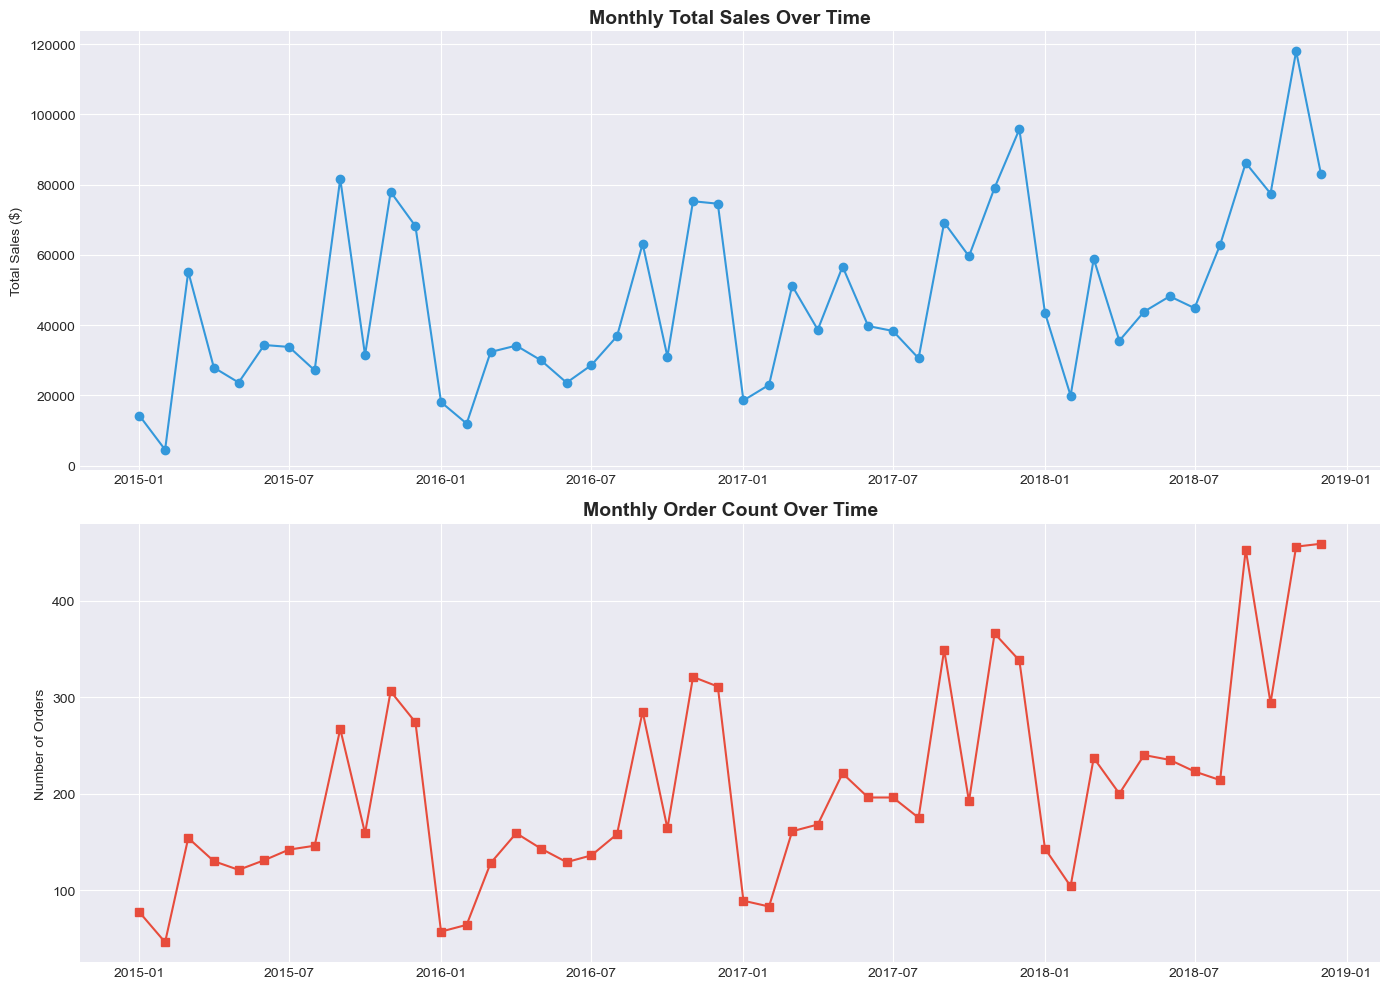

In [7]:
monthly_pd = monthly_sales.toPandas()
monthly_pd['date'] = pd.to_datetime(monthly_pd[['year', 'month']].assign(day=1))
monthly_pd = monthly_pd.sort_values('date')

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

axes[0].plot(monthly_pd['date'], monthly_pd['total_sales'], marker='o', color='#3498db')
axes[0].set_title('Monthly Total Sales Over Time', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Total Sales ($)')

axes[1].plot(monthly_pd['date'], monthly_pd['num_orders'], marker='s', color='#e74c3c')
axes[1].set_title('Monthly Order Count Over Time', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Orders')

plt.tight_layout()
plt.savefig(os.path.join(project_root, 'reports', 'figures', 'time_series_pyspark.png'), dpi=300)
plt.show()


MOVING AVERAGE CALCULATION (3-Month)


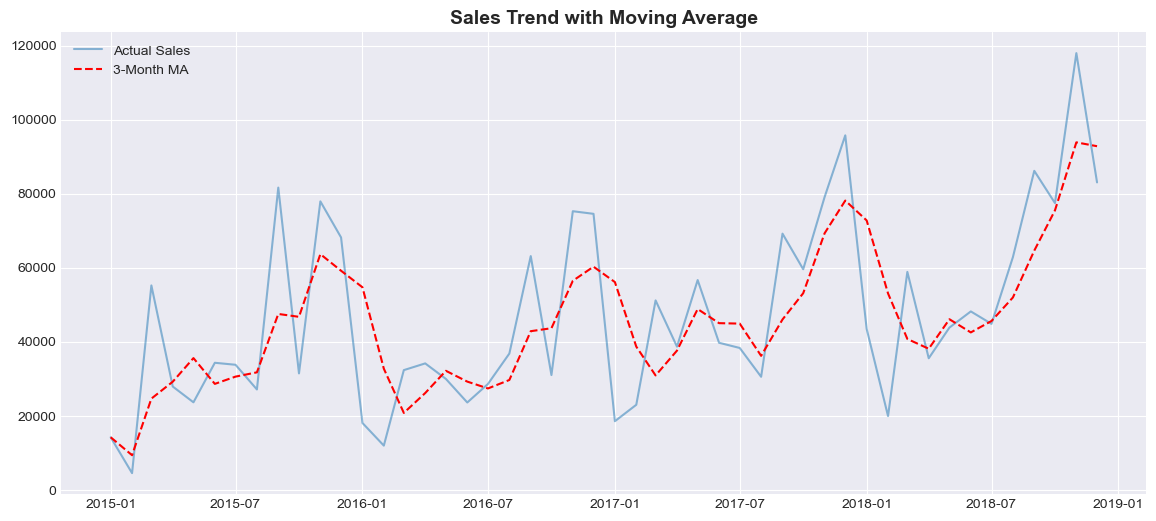

In [8]:
print("\n" + "="*70)
print("MOVING AVERAGE CALCULATION (3-Month)")
print("="*70)

window_spec = Window.orderBy('year', 'month').rowsBetween(-2, 0)

monthly_with_ma = monthly_sales.withColumn(
    'sales_ma_3m',
    avg('total_sales').over(window_spec)
)

ma_pd = monthly_with_ma.toPandas()
ma_pd['date'] = pd.to_datetime(ma_pd[['year', 'month']].assign(day=1))
ma_pd = ma_pd.sort_values('date')

plt.figure(figsize=(14, 6))
plt.plot(ma_pd['date'], ma_pd['total_sales'], label='Actual Sales', alpha=0.5)
plt.plot(ma_pd['date'], ma_pd['sales_ma_3m'], label='3-Month MA', linestyle='--', color='red')
plt.title('Sales Trend with Moving Average', fontsize=14, fontweight='bold')
plt.legend()
plt.show()

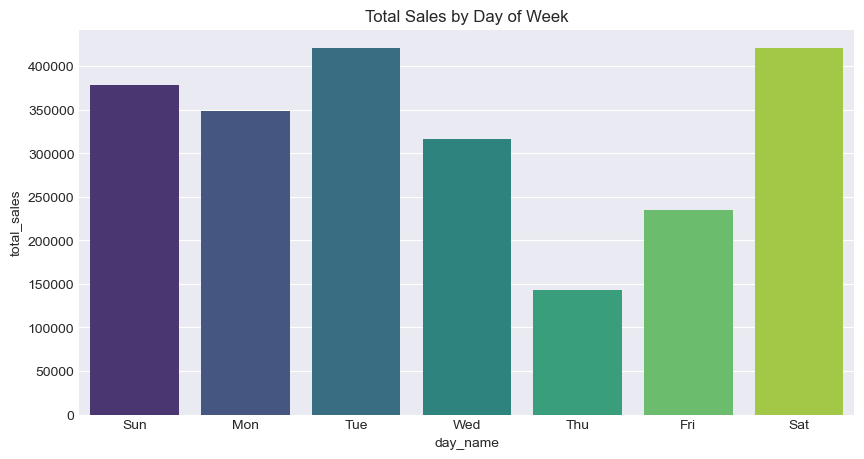

In [9]:
if 'Sales' in df.columns:
    dow_sales = df_time.groupBy('day_of_week') \
        .agg(spark_sum('Sales').alias('total_sales')) \
        .orderBy('day_of_week')
    
    dow_pd = dow_sales.toPandas()
    dow_pd['day_name'] = dow_pd['day_of_week'].map({
        1: 'Sun', 2: 'Mon', 3: 'Tue', 4: 'Wed', 5: 'Thu', 6: 'Fri', 7: 'Sat'
    })
    
    plt.figure(figsize=(10, 5))
    # Fixed the palette warning by assigning hue and setting legend=False
    sns.barplot(x='day_name', y='total_sales', data=dow_pd, hue='day_name', palette='viridis', legend=False)
    plt.title('Total Sales by Day of Week')
    plt.show()


In [10]:
print(f"\n📊 Summary Metrics:")
print(f"  • Avg Monthly Sales: ${monthly_pd['total_sales'].mean():,.2f}")
print(f"  • Sales Volatility: ${monthly_pd['total_sales'].std():,.2f}")

spark.stop()
print("\n✅ Spark session stopped successfully")


📊 Summary Metrics:
  • Avg Monthly Sales: $47,115.35
  • Sales Volatility: $24,978.69

✅ Spark session stopped successfully
